In [43]:
from typing import Dict
from cfgnet.network.network_configuration import NetworkConfiguration
from cfgnet.network.nodes import ArtifactNode
from cfgnet.network.network import Network
from pprint import pprint
from tqdm import tqdm
import git
import json
import subprocess
import traceback
import glob
import time

config_file_endings = (".xml", ".yml", ".yaml", "Dockerfile", ".ini", ".properties", ".conf", ".json", ".toml", ".cfg", "settings.py", ".cnf")

def checkout_latest_commit(repo, current_branch, latest_commit):
     # Return to the latest commit
    if current_branch:
        # If we were on a branch, return to it
        repo.git.checkout(current_branch)
        print(f"Returned to original branch: {current_branch}")
    else:
        # If we were in a detached HEAD state, checkout the latest commit directly
        repo.git.checkout(latest_commit)
        print(f"Returned to the latest commit: {latest_commit}")


def analyze_config_network(repo_path: str):
    
    network_config = NetworkConfiguration(
        project_root_abs=repo_path,
        enable_static_blacklist=False,
        enable_internal_links=True,
        enable_all_conflicts=True,
        enable_file_type_plugins=True,
        system_level=False
    )

    network = Network.init_network(cfg=network_config)

    artifacts = network.get_nodes(node_type=ArtifactNode)

    config_files_data = []
    for artifact in artifacts:
        pairs = artifact.get_pairs()

        config_files_data.append({
            "file_path": artifact.rel_file_path,
            "concept": artifact.concept_name,
            "options": len(artifact.get_pairs()),
            "pairs": pairs
        })


    config_files = set(artifact.rel_file_path for artifact in artifacts)
  	
    network_data = {
        "links": len(network.links),
        "config_files": list(config_files),
        "config_files_data": config_files_data
    }

    return network_data


def get_file_diff(repo_path: str, commit, file_path: str):
    if commit.parents:
        parent_commit = f"{commit.hexsha}^"
            
        try:                        
            # Run git diff to capture line-by-line changes
            diff_output = subprocess.check_output(
                ['git', 'diff', parent_commit, commit.hexsha, '--', file_path],
                cwd=repo_path,
                text=True
            )
            return diff_output
        except (subprocess.CalledProcessError, git.exc.GitCommandError) as e:
            print(f"Error running git diff for commit {commit.hexsha}: {e}")
            return None


def analyze_repository(repo_path: str, get_diff: bool = False) -> Dict:
    """Analyze Commit history of repositories and collect stats about the configuration space."""  
    start_time = time.time()
    project_name = repo_path.split("/")[-1]
    repo = git.Repo(repo_path)

    # Save the current branch to return to it later
    current_branch = repo.active_branch.name if not repo.head.is_detached else None
    latest_commit = repo.head.commit.hexsha
    parent_commit = None

    # Get all commits in the repository from oldest to newest
    commits = list(repo.iter_commits("HEAD"))[::-1]

    print(f"Number of commits: {len(commits)}")

    config_commit_data = []

    for commit in tqdm(commits, desc="Processing", total=len(commits)):

        is_config_related = False

        # Get commit stats
        stats = commit.stats.total

        # Checkout the commit
        repo.git.checkout(commit.hexsha)

        # check if commit is config-related
        if any(file_path.endswith(config_file_endings) for file_path in commit.stats.files.keys()):
            is_config_related = True
            
            # Run the external analysis for config-related commits
            try: 
                network_data = analyze_config_network(repo_path=repo_path)
            except Exception:
                print(f"Error occurred in commit {commit.hexsha}")
                print({traceback.print_exc()})
                return

            # Get general stats per config file
            for file_path, file_stats in commit.stats.files.items():
                
                # Get config file data
                if file_path in network_data["config_files"]:
                    file_data = next(filter(lambda x: x["file_path"] == file_path, network_data["config_files_data"]))
                    file_data["insertions"] = file_stats['insertions']
                    file_data["deletions"] = file_stats['deletions']
                    file_data["total_changes"] = file_stats['insertions'] + file_stats['deletions']

                    # Get config file diff
                    if get_diff:
                        diff_output = get_file_diff(
                            repo_path=repo_path,
                            commit=commit,
                            file_path=file_path
                        )

                        file_data["diff"] = diff_output

            config_commit_data.append(
                {   
                    "commit_hash": str(commit.hexsha),
                    "parent_commit": (parent_commit),
                    "is_config_related": is_config_related,
                    "author": f"{commit.author.name} <{commit.author.email}>",
                    "commit_mgs": str(commit.message),
                    "files_changed": stats['files'],
                    "insertions": stats['insertions'],
                    "deletions": stats['deletions'],
                    "network_data": network_data
                }
            )
        
        else:
            config_commit_data.append(
                {   
                    "commit_hash": str(commit.hexsha),
                    "parent_commit": (parent_commit),
                    "is_config_related": is_config_related,
                    "author": f"{commit.author.name} <{commit.author.email}>",
                    "commit_mgs": str(commit.message),
                    "files_changed": stats['files'],
                    "insertions": stats['insertions'],
                    "deletions": stats['deletions'],
                    "network_data": None
                }
            )


    # Return to latest commit
    checkout_latest_commit(
        repo=repo, 
        current_branch=current_branch,
        latest_commit=latest_commit
    )

    print(f"Len commit data: {len(config_commit_data)}, {round(len(config_commit_data)/len(commits), 2)}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.6f} seconds")
    
    return {
        "project_name": project_name,
        "analysis_time": elapsed_time,
        "len_commits": len(commits),
        "config_commit_data": config_commit_data
    }

In [ ]:
project_dir = "/home/simisimon/GitHub/cfgnet_evaluation"

for project_path in glob.glob(project_dir + "/**"):
    project_name = project_path.split("/")[-1]
    
    commit_data = analyze_repository(repo_path=project_path, get_diff=True)

    output_file = f"../data/analyzed_projects/{project_name}.json"

    print(f"Write commit data into file {output_file}")
    with open(output_file, "w", encoding="utf-8") as dest:
        json.dump(commit_data, dest, indent=2)

**Evolution of the confguration space of open-source software projects**

- statistics:
    - growth of config files
    - change frequency of config files
    - distribution of config-related and non-config-related commit
    - distribution of contributors that perform config changes
    - total number of options over time
    - total number of links over time

In [11]:
import json

data_file = "../data/analyzed_projects/test_project.json"

with open(data_file, "r", encoding="utf-8") as src:
    data = json.load(src)

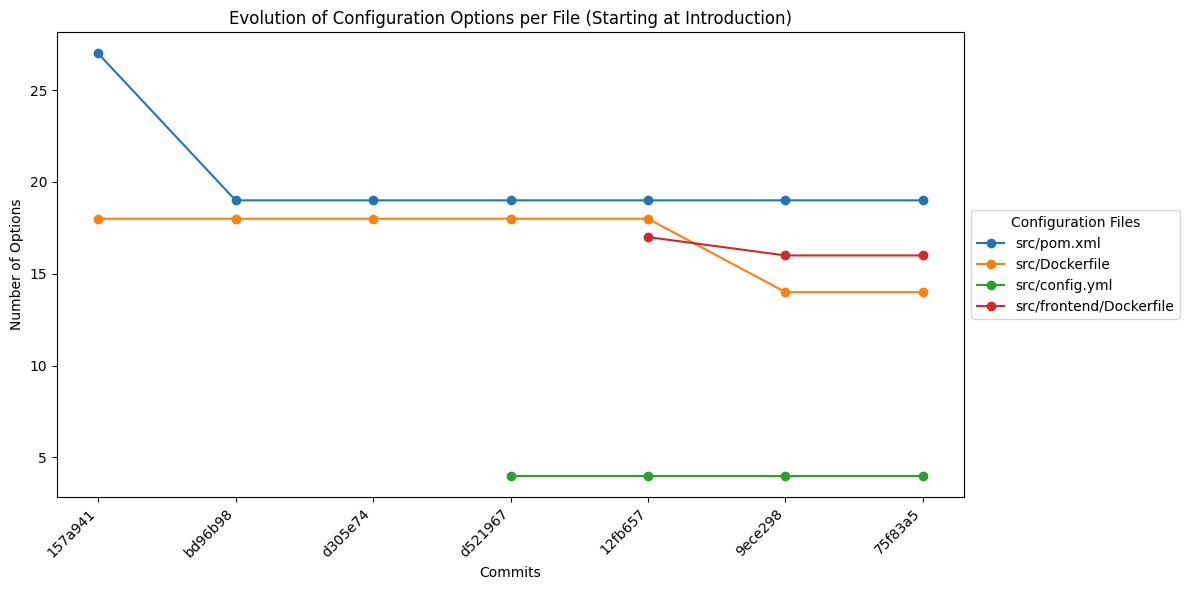

In [13]:
import matplotlib.pyplot as plt
from typing import List

def plot_config_file_evolution(data: List):
    # Extract data for plotting
    files = set()
    file_data = {}

    commit_data = [commit for commit in data["config_commit_data"] if commit["is_config_related"]]

    for commit in commit_data:
        commit_hash = commit["commit_hash"]
        for config_file in commit["network_data"]["config_files_data"]:
            file_path = config_file["file_path"]
            options = config_file["options"]
            files.add(file_path)
            if file_path not in file_data:
                file_data[file_path] = []
            file_data[file_path].append((commit_hash, options))

    # Prepare data for plotting
    x_ticks = [commit["commit_hash"] for commit in commit_data]

    # Adjust the plotting logic to start the line at the introduction commit
    file_lines = {file: [None] * len(x_ticks) for file in files}

    for file, changes in file_data.items():
        for commit_hash, options in changes:
            index = x_ticks.index(commit_hash)
            file_lines[file][index] = options

    # Replace None with previous values for continuity
    for file, options in file_lines.items():
        last_value = None
        for i in range(len(options)):
            if options[i] is None:
                options[i] = last_value
            else:
                last_value = options[i]

    shortened_x_ticks = [commit[:7] for commit in x_ticks]

    # Re-plot with shortened commit hashes
    plt.figure(figsize=(12, 6))
    for file, options in file_lines.items():
        plt.plot(shortened_x_ticks, options, marker="o", label=file)

    plt.xlabel("Commits")
    plt.ylabel("Number of Options")
    plt.title("Evolution of Configuration Options per File (Starting at Introduction)")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Configuration Files", loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()


plot_config_file_evolution(data=data)

**Evolution of the configuration options**


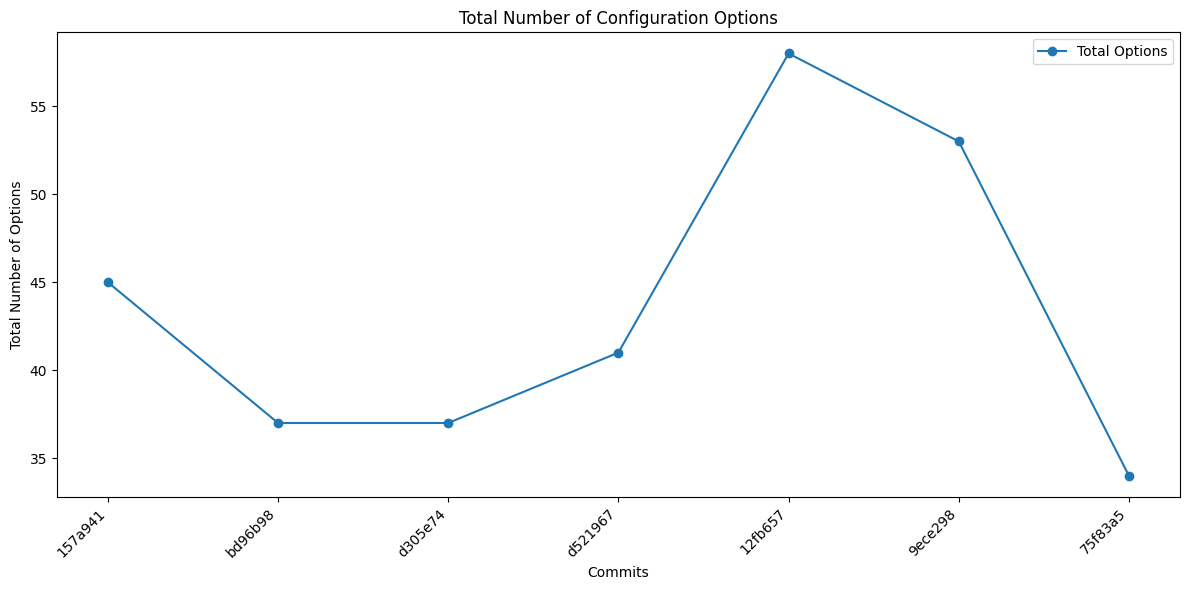

In [15]:
import matplotlib.pyplot as plt


def plot_num_options_evolution(data: List):
    # Extract data for plotting
    files = set()
    file_data = {}

    config_commit_data = [commit for commit in data["config_commit_data"] if commit["is_config_related"]]

    for commit in config_commit_data:
        commit_hash = commit["commit_hash"]
        for config_file in commit["network_data"]["config_files_data"]:
            file_path = config_file["file_path"]
            options = config_file["options"]
            files.add(file_path)
            if file_path not in file_data:
                file_data[file_path] = []
            file_data[file_path].append((commit_hash, options))

    # Prepare data for plotting
    x_ticks = [commit["commit_hash"] for commit in config_commit_data]

    shortened_x_ticks = [commit[:7] for commit in x_ticks]

    # Adjust the plotting logic to start the line at the introduction commit
    file_lines = {file: [None] * len(x_ticks) for file in files}

    for file, changes in file_data.items():
        for commit_hash, options in changes:
            index = x_ticks.index(commit_hash)
            file_lines[file][index] = options

    # Calculate the total number of options across all configuration files per commit
    total_options_per_commit = [0] * len(x_ticks)

    for file, options in file_lines.items():
        for i, option_count in enumerate(options):
            if option_count is not None:
                total_options_per_commit[i] += option_count

    # Plot the total number of options over time
    plt.figure(figsize=(12, 6))
    plt.plot(shortened_x_ticks, total_options_per_commit, marker="o", label="Total Options")

    plt.xlabel("Commits")
    plt.ylabel("Total Number of Options")
    plt.title("Total Number of Configuration Options")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_num_options_evolution(data=data)

**Evolution of links**

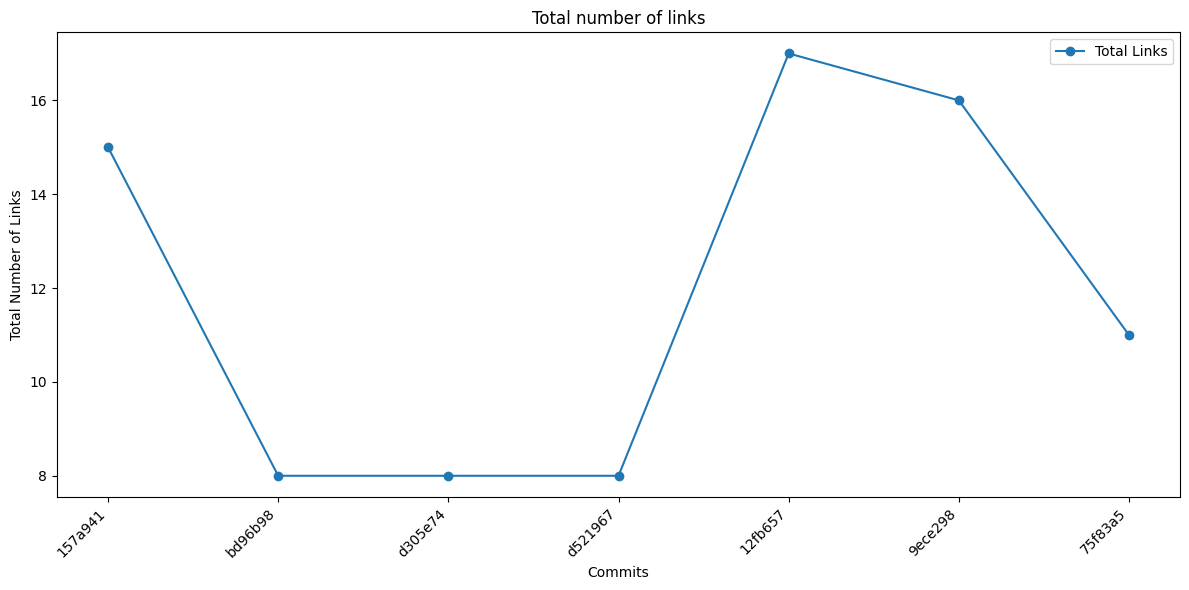

In [16]:
def plot_num_links_evolution(data: List):

    config_commit_data = [commit for commit in data["config_commit_data"] if commit["is_config_related"]]

    # Extract the total number of links per commit
    total_links_per_commit = [commit["network_data"]["links"] for commit in config_commit_data]

    # Shorten commit hashes for x-axis
    shortened_x_ticks = [commit["commit_hash"][:7] for commit in config_commit_data]

    # Plot the total number of links over time
    plt.figure(figsize=(12, 6))
    plt.plot(shortened_x_ticks, total_links_per_commit, marker="o", label="Total Links")

    plt.xlabel("Commits")
    plt.ylabel("Total Number of Links")
    plt.title("Total number of links")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_num_links_evolution(data=data)

**Distribution of config-related and non-config-related commits**

7


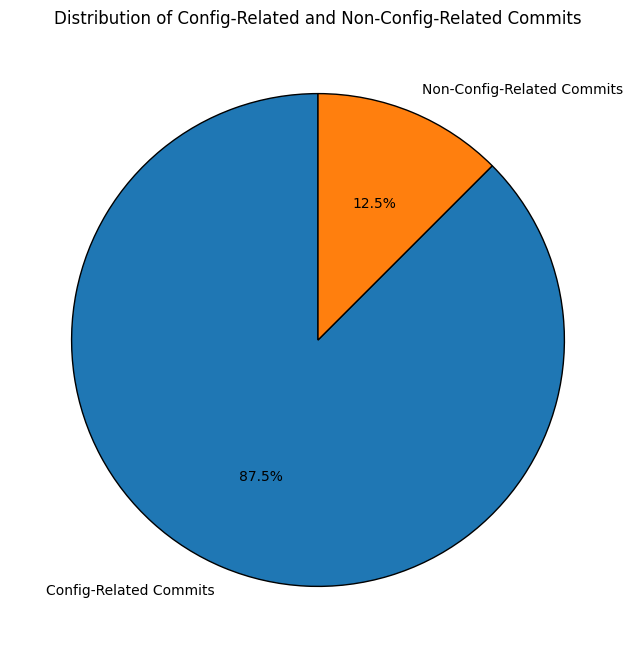

In [ ]:
import matplotlib.pyplot as plt

# TODO: as we only store config related commit, we need to calculate: # total commits/ # config related commits

def plot_config_commits_distribution(data: List):
    
    config_commit_data = [commit for commit in data["config_commit_data"] if commit["is_config_related"]]
    commit_data = [commit for commit in data["config_commit_data"] if not commit["is_config_related"]]

    assert len(config_commit_data) + len(commit_data) == data["len_commits"]

    # Data for the pie chart
    labels = ['Config-Related Commits', 'Non-Config-Related Commits']
    sizes = [len(config_commit_data), len(commit_data)]

    # Plot pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={'linewidth': 1, 'edgecolor': 'black'})
    plt.title("Distribution of Config-Related and Non-Config-Related Commits")
    plt.show()


plot_config_commits_distribution(data=data)

**Frequency how often a specific config file has changed**

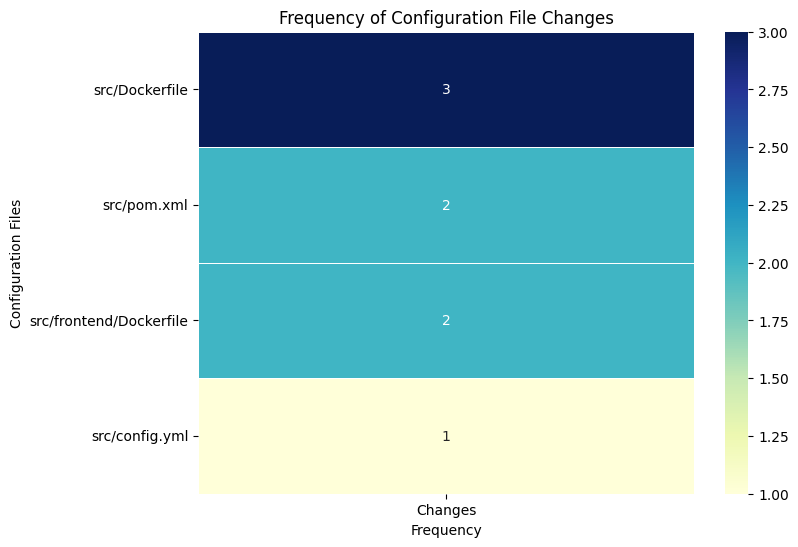

In [22]:
import seaborn as sns
import pandas as pd


def plot_config_file_changes_frequency(data: List):
    # Count how often each configuration file has changed
    config_commit_data = [commit for commit in data["config_commit_data"] if commit["is_config_related"]]

    file_change_counts = {}

    for commit in config_commit_data:
        for config_file in commit["network_data"]["config_files_data"]:
            file_path = config_file["file_path"]
            insertions = config_file.get("insertions", 0)
            deletions = config_file.get("deletions", 0)
            if insertions > 0 or deletions > 0:
                file_change_counts[file_path] = file_change_counts.get(file_path, 0) + 1

    # Convert data to a DataFrame for heatmap plotting
    file_change_df = pd.DataFrame(list(file_change_counts.items()), columns=["File", "Changes"])
    file_change_df = file_change_df.sort_values(by="Changes", ascending=False)

    # Create heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(file_change_df.set_index("File"), annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=0.5)

    plt.title("Frequency of Configuration File Changes")
    plt.xlabel("Frequency")
    plt.ylabel("Configuration Files")
    plt.show()

plot_config_file_changes_frequency(data=data)

**Contributors of Configuration Changes**

- TODO: Try to extract what concepts are changed by a contributor.

In [ ]:
def show_config_contributors(data: List):

    commit_data = data["config_commit_data"]
    contributor_config_changes = {}
    contributor_other_changes = {}

    for commit in commit_data:
        author = commit["author"]
        config_files_changed = any(
            "insertions" in file or "deletions" in file
            for file in commit["network_data"]["config_files_data"]
        ) if commit["network_data"] else None
        if author not in contributor_config_changes:
            contributor_config_changes[author] = 0
        if author not in contributor_other_changes:
            contributor_other_changes[author] = 0
        
        if config_files_changed:
            contributor_config_changes[author] += 1
        else:
            contributor_other_changes[author] += 1

    # Combine results into a DataFrame
    contributor_changes_combined_df = pd.DataFrame({
        "Contributor": contributor_config_changes.keys(),
        "Config Changes": contributor_config_changes.values(),
        "Other Changes": contributor_other_changes.values()
    }).sort_values(by=["Config Changes", "Other Changes"], ascending=False)

    print(contributor_changes_combined_df.head(10))

show_config_contributors(data=data)

                                     Contributor  Config Changes  \
0  Sebastian Simon <bastisimon95@googlemail.com>               6   

   Other Changes  
0              2  


**Taxonomy of configuration changes in X most popular open-source software projects**

- increase understading of configuration changes
    - which options change frequently?
    - what kind of options are added/removed?
    - why do these options change frequently? 

**Extract all options and collect all their values across the commit history**

In [44]:
import json

test_repo_path = "/home/simisimon/GitHub/projects/test_project_history"
commit_data = analyze_repository(repo_path=test_repo_path, get_diff=True)

with open("../data/analyzed_projects/test_project.json", "w", encoding="utf-8") as dest:
    json.dump(commit_data, dest, indent=2)

data_file = "../data/analyzed_projects/test_project.json"

with open(data_file, "r", encoding="utf-8") as src:
    data = json.load(src)

Number of commits: 8


Processing: 100%|██████████| 8/8 [00:00<00:00, 17.21it/s]


Returned to the latest commit: 75f83a5e3e6d046edb54b10320286f913d817d89
Len commit data: 8, 1.0
Elapsed time: 0.493782 seconds


In [55]:
import pandas as pd

# Extract all configuration data

config_commit_data = [commit for commit in data["config_commit_data"] if commit["is_config_related"]]
config_data = []

for commit in config_commit_data:
    
    for file_data in commit["network_data"]["config_files_data"]:
        for pair in file_data["pairs"]:
            config_data.append({
                "option": pair["option"],
                "value": pair["value"],
                "file_path": file_data["file_path"],
                "concept": file_data["concept"]
            })

# Create DataFrame from the extracted data
df = pd.DataFrame(config_data)

# Group by option, type, and file_path, and aggregate unique values
aggregated_df = (
    df.groupby(['file_path', 'option', 'concept'])['value']
    .apply(lambda x: sorted(list(set(x))))
    .reset_index()
)

# Rename columns for clarity
aggregated_df.columns = ['File Path', 'Option', 'Concept', 'Values']


aggregated_df['unchanged'] = aggregated_df['Values'].apply(lambda x: len(x) == 1)
aggregated_df['changed in project'] = aggregated_df['Values'].apply(lambda x: len(x) - 1 if len(x) > 1 else 0)

aggregated_df.to_csv("../data/test.csv", index=False)

aggregated_df


,File Path,Option,Concept,Values,unchanged,changed in project
0,src/Dockerfile,COPY.--from,docker,[build],True,0
1,src/Dockerfile,COPY.dest,docker,"[., ./src, app.jar]",False,2
2,src/Dockerfile,COPY.src,docker,[app/target/spring-boot-app-0.0.1-SNAPSHOT.jar...,False,2
3,src/Dockerfile,ENTRYPOINT.exec_command,docker,[java -jar app.jar],True,0
4,src/Dockerfile,ENTRYPOINT.param0,docker,[java],True,0
5,src/Dockerfile,ENTRYPOINT.param1,docker,[-jar],True,0
6,src/Dockerfile,ENTRYPOINT.param2,docker,[app.jar],True,0
7,src/Dockerfile,EXPOSE,docker,"[3000, 8080]",False,1
8,src/Dockerfile,FROM,docker,[eclipse-temurin:17-jdk-alpine],True,0
9,src/Dockerfile,FROM.image,docker,[maven:3.8.6-eclipse-temurin-17],True,0


**Extract all options, collect their values, and track if the option were removed somewhere in the commit history**